# Setup

Make sure you're in the spar-red-tem/owen directory

In [1]:
# %cd ..
%ls

Adapter.ipynb          REMEDI/                      Terminal commands.txt
lm_vector_arithmetic/  representation-engineering/  test_trainer/
Optimus_dir/           run_latent_generation.ipynb  visualization_demo.ipynb
__pycache__/           steering/                    wandb/


In [2]:
from transformers import Trainer, TrainingArguments
# import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
# from tqdm import tqdm
import torch
# import pandas as pd

# import numpy as np

# import accelerate

# Optimus

In [1]:
from Optimus_dir.code.Optimus import Optimus

# Compare effect of latent size

Seems like latent_size=32 makes the sentences "closer"? But reconstruction seems worse

Observations:
- Some latents get "translated" into either nothing or seemingly meaningless rambling. Some latents produce semantically similar words though.
- Longer sentences seem to reconstruct better than words/short sentences?

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Load Optimus with latent_size 32

In [4]:
#TODO decouple from Optimus
vae32 = Optimus(32)

We have added 3 tokens to GPT2


AttributeError: 'Optimus' object has no attribute 'device'

Load Optimus with latent_size 768

In [6]:
vae768 = Optimus(768)
# vae = vae.model_vae

We have added 3 tokens to GPT2


In [6]:
hidden = vae32.get_activations(vae32.latent_code_from_text('hello')[0], 'hello')
print (hidden.shape)

NameError: name 'vae32' is not defined

In [7]:
vae32.print_text(
    "love", 
    'hate', 
    'I love you so much!', 
    'I hate you so much!'
    )

"love" encoded and decoded:


Decoding 1: Sophia
Decoding 2: protagonist
Decoding 3: Chief?
Decoding 4: Alan Casciano
Decoding 5: Robin.


"hate" encoded and decoded:
Decoding 1: Nation
Decoding 2: ( A ^
Decoding 3: Call
Decoding 4: Man <PAD>
Decoding 5: The KAn.


"I love you so much!" encoded and decoded:
Decoding 1: Runew!
Decoding 2: You've made me happy."
Decoding 3: Hey All, glad I'm here.
Decoding 4: It's Kimmy."
Decoding 5: Oh, I really love you!


"I hate you so much!" encoded and decoded:
Decoding 1: I'm not happy and right?
Decoding 2: Every time I hit the person, I'm all crying.'
Decoding 3: You're going to change my mind!
Decoding 4: When you get angry and not spite her, I'm gonna sing you a song."
Decoding 5: I am sad that God shut me down.




In [8]:
vae768.print_text(
    "love", 
    'hate', 
    'I love you so much!', 
    'I hate you so much!'
    )

"love" encoded and decoded:
Decoding 1: 
Decoding 2: 46
Decoding 3: 
Decoding 4: 
Decoding 5: 


"hate" encoded and decoded:
Decoding 1: 87
Decoding 2: 
Decoding 3: 
Decoding 4: 
Decoding 5: 1


"I love you so much!" encoded and decoded:
Decoding 1: Love is like Romeo!'
Decoding 2: It is beautiful!"
Decoding 3: She stands for everything!
Decoding 4: It is splendid!"
Decoding 5: We have same love for you".


"I hate you so much!" encoded and decoded:
Decoding 1: There's someone singing me song tomorrow!"
Decoding 2: "I hate Grandpa Christine!"
Decoding 3: No they swear..."?
Decoding 4: Béhtina loves her.
Decoding 5: Tmed to call me 'pipe shill'.




In [9]:
shaq = "Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time."
benzene = "Benzene is a natural constituent of petroleum and is one of the elementary petrochemicals. Due to the cyclic continuous pi bonds between the carbon atoms, benzene is classed as an aromatic hydrocarbon. Benzene is a colorless and highly flammable liquid with a sweet smell, and is partially responsible for the aroma of gasoline."
vae32.print_text(shaq, benzene)
baseline_sports = "basketball " * 20
baseline_chemistry = "chemistry " * 20
vae32.print_text(baseline_sports, baseline_chemistry)

"Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time." encoded and decoded:


Decoding 1: Jean Patrick Done (nicknamed "Matt Done Weasel", "Shaneed Done", for about his skills as a linebacker, punt returner, middle defensive end, defensive back, middle linebacker, receiver), 6'1", 207 pounds and retired from professional football according to SportsPulse.
Decoding 2: Keller is a 2009 Senior State of Origin All-American, and is fifth in the Texas Bulbuls team of the year with 16.29:53:1, and third in the National Long Distance High School team with 18.29:51:1 with 33.5:31: Weight.
Decoding 3: Spangler of the NFL, Dash Grove, is a former youth football player, major league player and solo national champion who competed in the Senior National Football League (NFL), the Youth National Football League (NFL), the National Senior Football Game (NFL), the National Softball Little League (NFL), NCAA Division I Trojans, the National Senior Professional League (SEPA), and all other Division I leagues.
Decoding 4: Betkevich is a former 15–man, junior middleweight middleweig

In [10]:
vae768.print_text(shaq, benzene)

"Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time." encoded and decoded:


Decoding 1: Over the years Riley Hall, a former NBA defensive back, college center and NBA prospect who is also best known for being a Vezina Trophy finalist for Anthony Davis and passed for 226 points and 62 shots at the 1999 NBA Slam Dunk Contest, and a National Basketball Association record for 1825 fouls.
Decoding 2: Late Smyth, 6 feet 6", 185 pounds, left the NBA in 1985rd year of his late father, Drury Smyth Tallinn, who was drafted as one of the top power forwards in the League by the New York Knicks, and before he retired from the game.
Decoding 3: Reid is currently retired from football, sports and high school football, and his pro wrestling title is with the Cypriot Hezbollah National Fighting Championships in Patsy responded to Floyd Landay: "In eleven years, he considers himself as a nation's heaviest hitter around the bend, with a 752-pound frame (7.5 kg) frame."
Decoding 4: Rachael Evans (born March 8, 1961 and born July 6, 2002) is a leading college football player at th

In [11]:
vae32.print_text(shaq, benzene, perturb=0.01)

"Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time." encoded and decoded:


Decoding 1: Bob Belcher Born 6 June 1969, Evans is an American tennis player who is a former member of the "Tennis American Players" (UATL player of the Week), one of the most decorated professional players of all time at the University of Oklahoma and brought a heritage of winning medals for his country.
Decoding 2: Sherman is a baseball player who batting average and.412 on service in 39 games in Major League Baseball (22 with the Kansas City Royals), in a career last 18 months spanning 142 major league games (over 17,000 innings), so, Major League Baseball seems to have seen the versatile and from deep hitter.
Decoding 3: Steve Johnson is a skinny, 225-pound center, who is known as the "big brother" and White Cross Lindsay belongs to the 2007 Southwest Division Second Country Open and the 2009 Eastern Conference Second Country Olympic Nerrod, as he did for seven rounds organized by Promo Arena.
Decoding 4: Andrew Robinson is an American flyweight stover, who has won seven straight f

In [12]:
vae768.print_text(shaq, benzene, perturb=0.01)

"Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time." encoded and decoded:


Decoding 1: Genesi (born October 22, 1961) is a retired professional basketball player from Cazenovia who advanced to the NBA Draft from the Oakland A's affiliate team of the Hard Knocks in 1971, and play in 511 NBA seasons as well as an announcer for the Cleveland Cavaliers.
Decoding 2: Mr. Hayes ran for a gold medal in the 5000 metres at the 1984 London Olympics; twice surpassed by Lt. Tim Couch (170 metres), Jim Plummer (170 meters) and more than anyone of his position, both marathon runners.
Decoding 3: Major Patrick A. Rees-Mogg (born December 6, 1970) is a professional basketball player from Dallas, Texas, who played as a reserve guard and as a wide receiver (also balloting for Cowboys Mike Williams, Roy Rogers, and coaches Dick Morris and David Williams).
Decoding 4: Kaiser Wilcox is an American football figure (5-6), 5-10, with 8.51 yards and 184 receiving yards, including 3 induced touchdowns; and 5 career interceptions.
Decoding 5: By September 1986, PAW Miss Judge had travel

In [13]:
# Test optimus
text_love = "I love you so much!"
latent_love = vae32.latent_code_from_text(text_love)[0]
# text_hate = "I hate you so much!"
# latent_hate = vae32.latent_code_from_text(text_hate)[0]
print(latent_love.shape)
# # print(len(text_original))
# vae32.print_n_texts_from_latent_code(latent_love, 10)
# vae32.print_n_texts_from_latent_code(latent_hate, 10)
# vae32.print_n_texts_from_latent_code(latent_love - latent_hate, 10)
# vae32.print_n_texts_from_latent_code(-latent_love + latent_hate, 10)
# for i in range(10):
#     print(vae.text_from_latent_code(latent))

torch.Size([1, 32])


# Feature Visualization Trainer

In [14]:
# import matplotlib.pyplot as plt
def cosim(a, b):
    return nn.functional.cosine_similarity(a, b, dim=0)

class CustomTrainer(Trainer):
    def __init__(self, optimus, target_dir, training_args, latent):
        '''
        decoder: decoder model from an Optimus VAE, must have output_hidden_states=True
        target_dir: of size (1 + num_layers, 1, 1, latent_size)
        '''
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        latent.to(self.device)
        super().__init__(model=latent, args=training_args)
        self.decoder = optimus.model_decoder_with_hidden.to(self.device) # make sure this outputs hidden
        self.target_dir = target_dir.to(self.device).view(-1) #flattened
        # assert target_dir.shape == 
        context = optimus.model_vae.tokenizer_decoder.encode('<BOS>')
        context = torch.tensor(context, dtype=torch.long, device=self.device)
        self.context = context.unsqueeze(0).repeat(1, 1)  
        self.loss_values = []

    def compute_loss(self, latent, return_dir=False): 
        '''
        latent is a trainable parameter/model with shape [1, latent_size]
        '''
        #1. Extract params from latent model
        past = latent.get_parameter('latent')
        inputs = {'input_ids': self.context, 'past': past}
        
        #2. Put latent through vae decoder and Get hidden state
        hidden_states = self.decoder(**inputs)[2] # copied from Optimus.sample_sequence_conditional, don't know why this works
        current_dir = torch.stack(hidden_states).view(-1) # hidden_states reformated from list of tensors to single tensor
        if current_dir.shape != self.target_dir.shape:
            print(f'Target shape is {self.target_dir.shape} but current_dir shape is {current_dir.shape}')
            raise ValueError
        #3. Compute loss with cosine similarity between hidden states
        loss = cosim(current_dir, self.target_dir) 
        assert loss.numel() == 1, "Loss must be a scalar"
        
        return (loss, current_dir) if return_dir else loss
    
    

    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        num_epochs = int(self.args.num_train_epochs)
        for epoch in range(num_epochs):
            # for step, batch in enumerate(self.get_train_dataloader()):
            optimizer.zero_grad()
            latent = self.model
            loss = self.compute_loss(latent)
            loss.backward()
            optimizer.step()
            self.loss_values.append(loss.item())
            # if step % self.args.logging_steps == 0:
            #     print(f"Epoch {epoch}, Loss: {loss.item()}")
            # print(f"Epoch {epoch}, Loss: {loss.item()}")
        plt.plot(self.loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()


In [15]:
# Initialize trainer and run loop

# dummy_data = {'dummy':'dummy',} # may be needed to appease Trainer
# dummy_data = Dataset.from_dict(dummy_data)
def train(vae, latent_size, target_dir=None):
    training_args = TrainingArguments(output_dir="test_trainer")
    training_args.num_train_epochs = 1e3
    training_args.learning_rate = 1e-2
    # decoder = vae.model_decoder_with_hidden.to(device)
    if target_dir is None:
        target_dir = torch.randn(13, 1, 1, 768).to(device) #TODO: change to named constants
    else:
        assert target_dir.shape == (13, 1, 1, 768), "target_dir must have shape (13, 1, 1, 768)"
    latent = nn.Module()
    param = torch.randn(1, latent_size)
    param = nn.Parameter(data=param, requires_grad=True)
    latent.register_parameter("latent", param)
    latent.to(device)
    # original_latent = param.clone().detach().to(device)

    trainer = CustomTrainer(
        vae, target_dir, training_args, latent,
        # train_dataset=dummy_data,
        )
    trainer.train()
    vae.print_n_texts_from_latent_code(latent.get_parameter('latent'), 5)
    


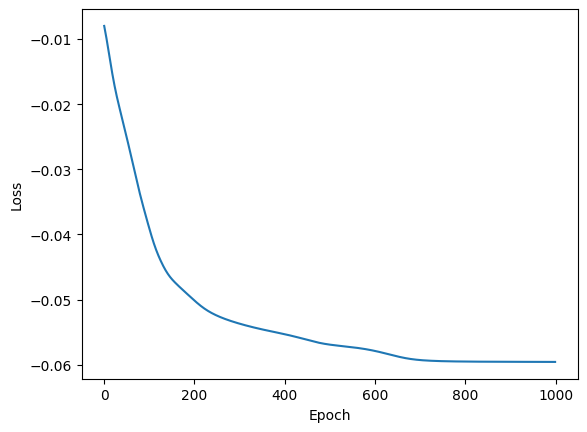

Decoding 1: 
Decoding 2: 
Decoding 3: 
Decoding 4: 
Decoding 5: 


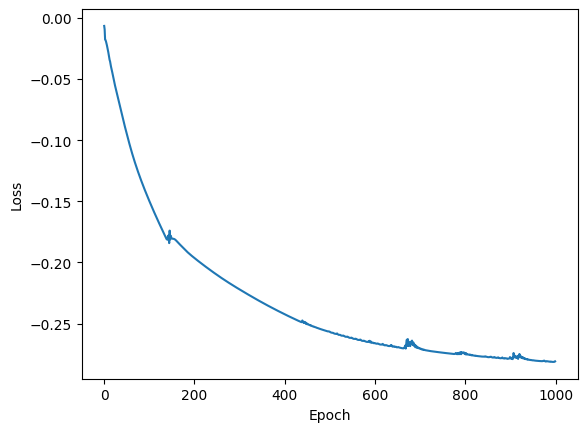

Decoding 1: "
Decoding 2: 
Decoding 3: other
Decoding 4: 
Decoding 5: C


In [16]:
train(vae32, 32)
train(vae768, 768)

Seems like post training we go to one/zero word sentences (from a random init latent). Maybe will help if we init from an actual sentence

Also may be a signal that the latent space is less 'dense' with meaningful sentences than we'd like. I thought using the latent=32 vae would help as sentences will be more 'densely packed' but empirically maybe this is evidence against that.

May also need to regularize to penalize distance against actual meaningful sentences in the latent space?